# Introduction to Julia

<img src="./julia_logo.png" align="center" width="400"/>

## Types of programming languages

* **Compiler languages**: C/C++, Fortran, ... 
  - Directly compiled to machine code that is executed by CPU 
  - Pros: fast, memory efficient
  - Cons: longer development time, hard to debug

* **Interpreter languages**: R, MATLAB, Python, SAS IML, JavaScript, ... 
  - Interpreted by interpreter
  - Pros: fast prototyping
  - Cons: excruciatingly slow for loops

* Mixed (dynamic) languages: Java
  - Compiled into *byte code* by the compiler, byte code is interpreted by the *virtual machine* (JVM). This scheme achieves architecture independence.
  - More and more interpreter languages are adopting JIT technology: R (version 3.4+), MATLAB (R2015b+), Python (PyPy), Julia, ...
      + functions will be compiled before execution on the first or second use. For subsequent uses (e.g., calling the function within a loop), the speedup is significant.

* Scripting languages: Linux shell scripts, Perl, ...
  - Interpreter languages quick to let computer do simple tasks.
  - Extremely useful for some data preprocessing and manipulation

* Database languages: SQL, Hive (Hadoop).  
  - Data analysis *never* happens if we do not know how to retrieve data from databases  

## Messages

* To be versatile in the big data era, master at least one language in each category.

* To improve efficiency of interpreted languages such as R or Matlab, conventional wisdom is to avoid loops as much as possible, aka, **vectorize** code
> The only loop you are allowed to have is that for an iterative algorithm.

* When looping is unavoidable, need to code in C, C++, or Fortran.  
Success stories: the popular `glmnet` package in R is coded in Fortran; `tidyverse` packages use a lot Rcpp/C++.

* Modern languages such as Julia tries to solve the **two language problem**:
    - Prototype code goes into a high-level language
    - Production code goes into a low-level language

## What's Julia?

> Julia is a high-level, high-performance dynamic programming language for technical computing, with syntax that is familiar to users of other technical computing environments

* History:
  - Project started in 2009. First public release in 2012 
  - Creators: Jeff Bezanson, Alan Edelman, Stefan Karpinski, Viral Shah
  - First major release v1.0 was released on Aug 8, 2018
  - Current stable release: v1.2.0

* Aim to solve the notorious **two language problem**: Prototype code goes into high-level languages like R/Python, production code goes into low-level language like C/C++. 

    Julia aims to:
> Walks like Python. Runs like C.

<img src="./julia_vs_otherlang.png" align="center" width="800"/>

See <https://julialang.org/benchmarks/> for the details of benchmark.

* Write high-level, abstract code that closely resembles mathematical formulas
    - yet produces fast, low-level machine code that has traditionally only been generated by static languages.

* Julia is more than just "Fast R" or "Fast Matlab"
    - Performance comes from features that work well together.  
    - You can't just take the magic dust that makes Julia fast and sprinkle it on [language of choice]

## R is great, but...

* The language encourages operating on the whole object (i.e. vectorized code). However, some tasks (e.g. MCMC) are not easily vectorized.

* Unvectorized R code (`for` and `while` loops) is slow.
  - http://adv-r.had.co.nz/Performance.html
    - Section on performance starts with "Why is R slow?" 

* Techniques for large data sets – parallelization, memory mapping, database access, map/reduce – can be used but not easily. R is single threaded and most likely will stay that way.

* R functions should obey functional semantics (not modify arguments). Okay until you have very large objects on which small changes are made during parameter estimation.

* Sort-of object oriented using generic functions but implementation is casual. Does garbage collection but not based on reference counting.

* The real work is done in underlying C code and it is not easy to trace your way through it.

(by [Doug Bates](http://pages.stat.wisc.edu/~bates/), member of the R Core Team, `Matrix` and `lme4`)

* Deficiencies in the core language 
  - Many fixed with packages (`devtools`, `roxygen2`, `Matrix`)
  - Others harder to fix (R uses an old version of BLAS)
  - Some impossible to fix (clunky syntax, poor design choices)
 
* Doug Bates' [Julia package for mixed-effects models](https://github.com/dmbates/MixedModels.jl)
    - Getting Doug on board was a big win for statistics with Julia, as he brought a lot of knowledge about the history of R development and design choices
    
    > As some of you may know, I have had a (rather late) mid-life crisis and run off with another language called Julia.   
    >
    > -- <cite>Doug Bates (on the [`knitr` Google Group](https://groups.google.com/forum/#!msg/knitr/F78PBMIamwk/X-d-zUhrdrkJ), 2013)</cite>

## Gibbs sampler example by Doug Bates

* An example from Doug Bates' [Julia for R Programmers](http://www.stat.wisc.edu/~bates/JuliaForRProgrammers.pdf) slides.

* The task is to create a Gibbs sampler for the density  
$$
f(x, y) = k x^2 exp(- x y^2 - y^2 + 2y - 4x), x > 0
$$
using the conditional distributions
$$
\begin{eqnarray*}
  X | Y &\sim& \Gamma \left( 3, \frac{1}{y^2 + 4} \right) \quad \text{(shape, scale)}\\
  Y | X &\sim& N \left(\frac{1}{1+x}, \frac{1}{2(1+x)} \right).
\end{eqnarray*}
$$

* R solution. The `RCall.jl` package allows us to execute R code without leaving the `Julia` environment. We first define an R function `Rgibbs()`.

In [208]:
using Pkg
Pkg.activate("../..")
Pkg.status()

Status `~/Dropbox/class/M1399.000200/2020/Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [31c24e10] Distributions v0.23.10
  [438e738f] PyCall v1.91.4
  [6f49c342] RCall v0.13.7
  [8f399da3] Libdl 
  [10745b16] Statistics 


 Activating environment at `~/Dropbox/class/M1399.000200/2020/Project.toml`


In [145]:
using RCall

R"""
library(Matrix)
Rgibbs <- function(N, thin) {
  mat <- matrix(0, nrow=N, ncol=2)
  x <- y <- 0
  for (i in 1:N) {
    for (j in 1:thin) {
      x <- rgamma(1, 3, y * y + 4) # 3rd arg is rate
      y <- rnorm(1, 1 / (x + 1), 1 / sqrt(2 * (x + 1)))
    }
    mat[i,] <- c(x, y)
  }
  mat
}
"""

┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1260


RObject{ClosSxp}
function (N, thin) 
{
    mat <- matrix(0, nrow = N, ncol = 2)
    x <- y <- 0
    for (i in 1:N) {
        for (j in 1:thin) {
            x <- rgamma(1, 3, y * y + 4)
            y <- rnorm(1, 1/(x + 1), 1/sqrt(2 * (x + 1)))
        }
        mat[i, ] <- c(x, y)
    }
    mat
}


To generate a sample of size 10,000 with a thinning of 500. How long does it take?

In [146]:
R"""
system.time(Rgibbs(10000, 500))
"""

RObject{RealSxp}
   user  system elapsed 
 21.113   1.626  22.760 


* This is a Julia function for the simple Gibbs sampler:

In [147]:
using Distributions

function jgibbs(N, thin)
    mat = zeros(N, 2)
    x = y = 0.0
    for i in 1:N
        for j in 1:thin
            x = rand(Gamma(3, 1 / (y * y + 4)))
            y = rand(Normal(1 / (x + 1), 1 / sqrt(2(x + 1))))
        end
        mat[i, 1] = x
        mat[i, 2] = y
    end
    mat
end

jgibbs (generic function with 1 method)

Generate the same number of samples. How long does it take?

In [148]:
jgibbs(100, 5); # warm-up
@elapsed jgibbs(10000, 500)

0.323224098

We see 40-80 fold speed up of `Julia` over `R` on this example, **with similar coding effort**!

## Learning resources

0. [Julia: A Fresh Approach to Numerical Computing](../../readings/BezansonEdelmanKarpinskiShah17Julia.pdf) by Jeff Bezanson, Alan Edelman, Stefan Karpinski, and Viral B. Shah, *SIAM REVIEW* Vol. 59, No. 1, pp. 65–98.

1. [Julia for R Programmers](http://www.stat.wisc.edu/~bates/JuliaForRProgrammers.pdf) by Doug Bates.

2. YouTube: [Intro to Julia](https://www.youtube.com/watch?v=8h8rQyEpiZA&t) (2h28m), by Jane Herriman. 

3. Cheat sheet: [The Fast Track to Julia](https://juliadocs.github.io/Julia-Cheat-Sheet/).  

4. Browse the Julia [documentation](https://docs.julialang.org/en).  

5. For R users, read [Noteworthy Differences From R](https://docs.julialang.org/en/v1/manual/noteworthy-differences/#Noteworthy-differences-from-R-1).  

    For Python users, read [Noteworthy Differences From Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/?highlight=matlab#Noteworthy-differences-from-Python-1).  

    For Matlab users, read [Noteworthy Differences From Matlab](https://docs.julialang.org/en/v1/manual/noteworthy-differences/#Noteworthy-differences-from-MATLAB-1).  


6. The [Learning page](http://julialang.org/learning/) on Julia's website has pointers to many other learning resources.  

## Julia REPL (Read-Evaluation-Print-Loop)

The `Julia` REPL, or `Julia` shell, has at least five modes.

1. **Default mode** is the Julian prompt `julia>`. *Type backspace in other modes* to return to the default mode.    

2. **Help mode** `help?>`. Type `?` to enter help mode. `?search_term` does a fuzzy search for `search_term`.  

3. **Shell mode** `shell>`. Type `;` to enter shell mode.  

4. **Package mode** `(v1.1) pkg>`. Type `]` to enter package mode for managing Julia packages (install, uninstall, update, ...).

5. **Search mode** `(reverse-i-search)`. Press `ctrl+R` to enter search model. 

6. With `RCall.jl` package installed, we can enter the **R mode** by typing `$` (shift+4) at Julia REPL.

Some survival commands in Julia REPL:  
1. `quit()` or `Ctrl+D`: exit Julia.

2. `Ctrl+C`: interrupt execution.

3. `Ctrl+L`: clear screen.

0. Append `;` (semi-colon) to suppress displaying output from a command. Same as Matlab.

0. `include("filename.jl")` to source a Julia code file.

## Seek help

* Online help from REPL: `?function_name`.

* Google (~~Naver~~).

* Julia documentation: <https://docs.julialang.org/en/>.

* Look up source code: `@edit fun(x)`.

* <https://discourse.julialang.org>.

* Friends.

## Which IDE?

* Julia homepage lists many choices: Juno, VS Code, Vim, ...

* Unfortunately at the moment there are no mature RStudio- or Matlab-like IDE for Julia yet.

* For dynamic document, e.g., homework, I recommend [Jupyter Notebook](https://jupyter.org/install.html) or [JupyterLab](http://jupyterlab.readthedocs.io/en/stable/). JupyterLab is supposed to replace Jupyter Notebook after it reaches v1.0.

* For extensive Julia coding, I myself use the [vi](https://won-j.github.io/326_621a-2018fall/lectures/02-linux/linux2.html#vi). Use whatever editor you like.


## Julia package system

* Each Julia package is a Git repository. Each Julia package name ends with `.jl`. E.g., `Distributions.jl` package lives at <https://github.com/JuliaStats/Distributions.jl>.   
Google search with `PackageName.jl` usually leads to the package on github.com. 

* The package ecosystem is rapidly maturing; a complete list of **registered** packages (which are required to have a certain level of testing and documentation) is at [http://pkg.julialang.org/](http://pkg.julialang.org/).

* For example, the package called `Distributions.jl` is added with
```julia
# in Pkg mode
(v1.1) pkg> add Distributions
```
and "removed" (although not completely deleted) with
```julia
# in Pkg mode
(v1.1) pkg> rm Distributions
```
* The package manager provides a dependency solver that determines which packages are actually required to be installed.

* **Non-registered** packages are added by cloning the relevant Git repository. E.g.,
```julia
# in Pkg mode
(v1.1) pkg> add https://github.com/OpenMendel/SnpArrays.jl
```

* A package needs only be added once, at which point it is downloaded into your local `.julia/packages` directory in your home directory. 

In [153]:
using Pkg
Pkg.activate("../..")
Pkg.dependencies()

 Activating environment at `~/Dropbox/class/M1399.000200/2020/Project.toml`


Dict{Base.UUID,Pkg.Types.PackageInfo} with 61 entries:
  UUID("34da2185-b29b-5c13… => PackageInfo("Compat", v"3.15.0", "215f1c81cfd1c5…
  UUID("ade2ca70-3891-5945… => PackageInfo("Dates", nothing, nothing, false, fa…
  UUID("8dfed614-e22c-5e08… => PackageInfo("Test", nothing, nothing, false, fal…
  UUID("82899510-4779-5014… => PackageInfo("IteratorInterfaceExtensions", v"1.0…
  UUID("e2d170a0-9d28-54be… => PackageInfo("DataValueInterfaces", v"1.0.0", "bf…
  UUID("e1d29d7a-bbdc-5cf2… => PackageInfo("Missings", v"0.4.4", "ed61674a08648…
  UUID("a93c6f00-e57d-5684… => PackageInfo("DataFrames", v"0.21.7", "a7c1c9a6e4…
  UUID("56ddb016-857b-54e1… => PackageInfo("Logging", nothing, nothing, false, …
  UUID("864edb3b-99cc-5e75… => PackageInfo("DataStructures", v"0.18.2", "88a936…
  UUID("10745b16-79ce-11e8… => PackageInfo("Statistics", nothing, nothing, fals…
  UUID("8f4d0f93-b110-5947… => PackageInfo("Conda", v"1.4.1", "7a58bb32ce5d85f8…
  UUID("8bb1440f-4735-579b… => PackageInfo("DelimitedF

* Directory of a specific package can be queried by `pathof()`:

In [154]:
using Distributions

pathof(Distributions)

"/Users/jhwon/.julia/packages/Distributions/G4nDk/src/Distributions.jl"

* If you start having problems with packages that seem to be unsolvable, you may try just deleting your .julia directory and reinstalling all your packages. 

* Periodically, one should run `update` in Pkg mode, which checks for, downloads and installs updated versions of all the packages you currently have installed.

* `status` lists the status of all installed packages.

* Using functions in package.
```julia
using Distributions
```
This pulls all of the *exported* functions in the module into your local namespace, as you can check using the `whos()` command. An alternative is
```julia
import Distributions
```
Now, the functions from the Distributions package are available only using 
```julia
Distributions.<FUNNAME>
```
All functions, not only exported functions, are always available like this.

## Calling R from Julia

* The [`RCall.jl`](https://github.com/JuliaInterop/RCall.jl) package allows us to embed R code inside of Julia.

* There are also `PyCall.jl`, `MATLAB.jl`, `JavaCall.jl`, `CxxWrap.jl` packages for interfacing with other languages.

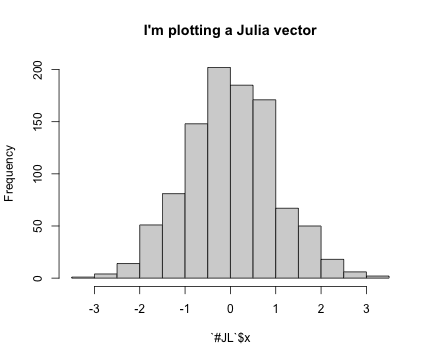

RObject{VecSxp}
$breaks
 [1] -3.5 -3.0 -2.5 -2.0 -1.5 -1.0 -0.5  0.0  0.5  1.0  1.5  2.0  2.5  3.0  3.5

$counts
 [1]   1   4  14  51  81 148 202 185 171  67  50  18   6   2

$density
 [1] 0.002 0.008 0.028 0.102 0.162 0.296 0.404 0.370 0.342 0.134 0.100 0.036
[13] 0.012 0.004

$mids
 [1] -3.25 -2.75 -2.25 -1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75  2.25
[13]  2.75  3.25

$xname
[1] "`#JL`$x"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


In [155]:
using RCall

x = randn(1000)
R"""
hist($x, main="I'm plotting a Julia vector")
"""

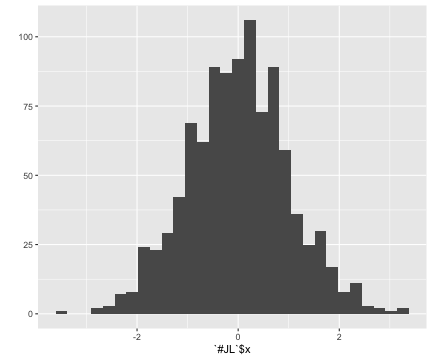

RObject{VecSxp}


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /Users/jhwon/.julia/packages/RCall/Qzssx/src/io.jl:160


In [156]:
R"""
library(ggplot2)
qplot($x)
"""

In [157]:
x = R"""
rnorm(10)
"""

RObject{RealSxp}
 [1] -1.0171772  0.5898648  0.8162035 -1.5763040  0.4807966 -0.4020459
 [7]  0.9717939 -0.9082865 -0.6897575 -0.4534296


In [158]:
# collect R variable into Julia workspace
y = collect(x)

10-element Array{Float64,1}:
 -1.017177200537361
  0.5898647855206323
  0.816203513186847
 -1.5763039673887582
  0.4807966256929533
 -0.402045947841594
  0.9717938561289129
 -0.9082864667410552
 -0.6897574878051502
 -0.4534296092742011

* Access Julia variables in R REPL mode:
```julia
julia> x = rand(5) # Julia variable
R> y <- $x
```

* Pass Julia expression in R REPL mode:
```julia
R> y <- $(rand(5))
```

* Put Julia variable into R environment:
```julia
julia> @rput x
R> x
```

* Get R variable into Julia environment:
```julia
R> r <- 2
Julia> @rget r
```

* If you want to call Julia within R, check out the [`XRJulia`](https://cran.r-project.org/web/packages/XRJulia/) package by John Chambers.

## Some basic Julia code

In [159]:
# an integer, same as int in R
y = 1
typeof(y) 

Int64

In [160]:
# a Float64 number, same as double in R
y = 1.0
typeof(y) 

Float64

In [161]:
# Greek letters:  `\pi<tab>`
π

π = 3.1415926535897...

In [162]:
typeof(π)

Irrational{:π}

In [163]:
# Greek letters:  `\theta<tab>`
θ = y + π

4.141592653589793

In [164]:
# emoji! `\:kissing_cat:<tab>`
😽 = 5.0

5.0

In [165]:
# `\alpha<tab>\hat<tab>`
α̂ = π

π = 3.1415926535897...

In [166]:
# vector of Float64 0s
x = zeros(5)

5-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [167]:
# vector Int64 0s
x = zeros(Int, 5)

5-element Array{Int64,1}:
 0
 0
 0
 0
 0

In [168]:
# matrix of Float64 0s
x = zeros(5, 3)

5×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [169]:
# matrix of Float64 1s
x = ones(5, 3)

5×3 Array{Float64,2}:
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [170]:
# define array without initialization
x = Matrix{Float64}(undef, 5, 3)

5×3 Array{Float64,2}:
 0.0           0.0           0.0
 0.0           0.0           0.0
 2.30753e-314  2.30753e-314  0.0
 0.0           0.0           0.0
 0.0           0.0           0.0

In [171]:
# fill a matrix by 0s
fill!(x, 0)

5×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [172]:
# initialize an array to be constant 2.5
fill(2.5, (5, 3))

5×3 Array{Float64,2}:
 2.5  2.5  2.5
 2.5  2.5  2.5
 2.5  2.5  2.5
 2.5  2.5  2.5
 2.5  2.5  2.5

In [173]:
# rational number
a = 3//5

3//5

In [174]:
typeof(a)

Rational{Int64}

In [175]:
b = 3//7

3//7

In [176]:
a + b

36//35

In [177]:
# uniform [0, 1) random numbers
x = rand(5, 3)

5×3 Array{Float64,2}:
 0.929432  0.346201  0.591141
 0.268191  0.185181  0.223105
 0.586101  0.216678  0.107443
 0.477795  0.185574  0.301928
 0.993182  0.51187   0.88315

In [178]:
# uniform random numbers (in Float16)
x = rand(Float16, 5, 3)

5×3 Array{Float16,2}:
 0.502   0.334   0.291
 0.336   0.1846  0.2793
 0.795   0.507   0.3525
 0.0879  0.1133  0.632
 0.6885  0.6006  0.9863

In [179]:
# random numbers from {1,...,5}
x = rand(1:5, 5, 3)

5×3 Array{Int64,2}:
 2  2  5
 2  4  4
 2  1  3
 1  3  1
 2  3  4

In [180]:
# standard normal random numbers
x = randn(5, 3)

5×3 Array{Float64,2}:
 -0.210356   1.74295    1.6302
 -0.773528  -0.35579   -1.14257
 -2.43072    2.45504   -0.195585
  0.741599  -0.410961   1.37844
 -0.786453  -0.848862  -1.31378

In [181]:
# range
1:10

1:10

In [182]:
typeof(1:10)

UnitRange{Int64}

In [183]:
1:2:10

1:2:9

In [184]:
typeof(1:2:10)

StepRange{Int64,Int64}

In [185]:
# integers 1-10
x = collect(1:10)

10-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [186]:
# or equivalently
[1:10...]

10-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [187]:
# Float64 numbers 1-10
x = collect(1.0:10)

10-element Array{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [188]:
# convert to a specific type
convert(Vector{Float64}, 1:10)

10-element Array{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

## Timing and benchmark

### Julia

`@time`, `@elapsed`, `@allocated` macros:

In [189]:
using Random # standard library
Random.seed!(123) # seed
x = rand(1_000_000) # 1 million random numbers in [0, 1)

@time sum(x) # first run includes compilation time

  0.000494 seconds (7 allocations: 384 bytes)


500060.34072352527

In [190]:
@time sum(x) # no compilation time after first run

  0.000631 seconds (1 allocation: 16 bytes)


500060.34072352527

In [191]:
# just the runtime
@elapsed sum(x)

0.000491046

In [192]:
# just the allocation
@allocated sum(x)

16

Use package `BenchmarkTools.jl` for more robust benchmarking. Analog of `microbenchmark` package in R.

In [195]:
using BenchmarkTools

bm = @benchmark sum($x)  # '$' to avoid problems with globals

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     253.474 μs (0.00% GC)
  median time:      303.511 μs (0.00% GC)
  mean time:        311.108 μs (0.00% GC)
  maximum time:     571.935 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [197]:
using Statistics # standard library
benchmark_result = Dict() # a dictionary to store median runtime (in milliseconds)
benchmark_result["Julia builtin"] = median(bm.times) / 1e6

0.303511

### C

We would use the low-level C code as the baseline for copmarison. In Julia, we can easily run compiled C code using the `ccall` function. This is similar to `.C` in R.

In [198]:
using Libdl

C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file

# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -std=c99 -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [199]:
# make sure it gives same answer
c_sum(x)

500060.340723512

In [200]:
bm = @benchmark c_sum($x)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     1.021 ms (0.00% GC)
  median time:      1.462 ms (0.00% GC)
  mean time:        1.448 ms (0.00% GC)
  maximum time:     2.517 ms (0.00% GC)
  --------------
  samples:          3442
  evals/sample:     1

In [201]:
# store median runtime (in milliseconds)
benchmark_result["C"] = median(bm.times) / 1e6

1.4619125

### R, builtin `sum`

Next we compare to the build in `sum` function in R, which is implemented using C.

In [203]:
using RCall

R"""
library(microbenchmark)
y <- $x
rbm <- microbenchmark(sum(y))
"""

RObject{VecSxp}
Unit: microseconds
   expr     min       lq     mean   median       uq      max neval
 sum(y) 966.534 1216.206 1290.973 1260.697 1402.682 1572.731   100


In [204]:
# store median runtime (in milliseconds)
@rget rbm # dataframe
benchmark_result["R builtin"] = median(rbm[!, :time]) / 1e6

1.260697

### R, handwritten loop

Handwritten loop in R is much slower.

In [205]:
using RCall

R"""
sum_r <- function(x) {
  s <- 0
  for (xi in x) {
    s <- s + xi
  }
  s
}
library(microbenchmark)
y <- $x
rbm <- microbenchmark(sum_r(y))
"""

RObject{VecSxp}
Unit: milliseconds
     expr      min       lq     mean   median       uq      max neval
 sum_r(y) 13.18002 13.67156 14.03637 13.97077 14.14817 17.54083   100


In [206]:
# store median runtime (in milliseconds)
@rget rbm # dataframe
benchmark_result["R loop"] = median(rbm[!, :time]) / 1e6

13.9707695

### Python, builtin `sum`

Built in function `sum` in Python.

In [209]:
using PyCall
PyCall.pyversion

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1260


v"3.7.3"

In [211]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")
bm = @benchmark $pysum($x)

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     76.876 ms (0.00% GC)
  median time:      80.593 ms (0.00% GC)
  mean time:        80.661 ms (0.00% GC)
  maximum time:     84.522 ms (0.00% GC)
  --------------
  samples:          62
  evals/sample:     1

In [212]:
# store median runtime (in miliseconds)
benchmark_result["Python builtin"] = median(bm.times) / 1e6

80.592829

### Python, handwritten loop

In [213]:
using PyCall

py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

bm = @benchmark $sum_py($x)

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     91.920 ms (0.00% GC)
  median time:      95.955 ms (0.00% GC)
  mean time:        96.297 ms (0.00% GC)
  maximum time:     102.380 ms (0.00% GC)
  --------------
  samples:          52
  evals/sample:     1

In [214]:
# store median runtime (in miliseconds)
benchmark_result["Python loop"] = median(bm.times) / 1e6

95.954666

### Python, numpy

Numpy is the high-performance scientific computing library for Python.

In [215]:
# bring in sum function from Numpy 
numpy_sum = pyimport("numpy")."sum"

PyObject <function sum at 0x1467937b8>

In [216]:
bm = @benchmark $numpy_sum($x)

BenchmarkTools.Trial: 
  memory estimate:  352 bytes
  allocs estimate:  7
  --------------
  minimum time:     309.862 μs (0.00% GC)
  median time:      328.864 μs (0.00% GC)
  mean time:        352.526 μs (0.00% GC)
  maximum time:     814.863 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [217]:
# store median runtime (in miliseconds)
benchmark_result["Python numpy"] = median(bm.times) / 1e6

0.328864

Numpy performance is on a par with Julia built-in `sum` function. Both are about 3 times faster than C, probably because of insufficient optimization in compliation and overhead of passing Julia objects and receiving C pointers.

### Summary

In [218]:
benchmark_result

Dict{Any,Any} with 7 entries:
  "R builtin"      => 1.2607
  "Julia builtin"  => 0.303511
  "Python builtin" => 80.5928
  "C"              => 1.46191
  "Python loop"    => 95.9547
  "Python numpy"   => 0.328864
  "R loop"         => 13.9708

* `C` and `R builtin` are the baseline C performance (gold standard).

* `Python builtin` and `Python loop` are 80-100 fold slower than C because the loop is interpreted.

* `R loop` is about 30 folder slower than C and indicates the performance of bytecode generated by its compiler package (turned on by default since R v3.4.0 (Apr 2017)). 

* `Julia builtin` and `Python numpy` are 3-4 fold faster than C.

## Matrices and vectors

### Dimensions

In [219]:
x = randn(5, 3)

5×3 Array{Float64,2}:
  0.0772719  -1.15528   -1.34392
 -0.368893   -0.461129  -0.751211
  0.417419   -0.233825   1.86054
  1.37777    -1.02853    1.25315
 -0.174343   -0.167364  -0.048645

In [220]:
size(x)

(5, 3)

In [221]:
size(x, 1) # nrow() in R

5

In [222]:
size(x, 2) # ncol() in R

3

In [223]:
# total number of elements
length(x)

15

### Indexing

In [224]:
# 5 × 5 matrix of random Normal(0, 1)
x = randn(5, 5)

5×5 Array{Float64,2}:
  1.55945    0.206102  -0.970395    -0.470725   0.914685
 -2.91983    1.11212    0.129924     0.847761   0.93156
 -0.332333   0.377656  -0.515874    -0.287684   0.526302
  1.74769   -0.995194  -0.00500941  -0.230729  -0.769489
 -0.537634   1.48176    1.09383      1.50156   -1.53586

In [225]:
# first column
x[:, 1]

5-element Array{Float64,1}:
  1.5594514198472693
 -2.9198328529265063
 -0.3323330969364883
  1.7476879423484082
 -0.5376336547023547

In [226]:
# first row
x[1, :]

5-element Array{Float64,1}:
  1.5594514198472693
  0.20610195509092738
 -0.9703946888905491
 -0.47072457016547875
  0.9146848256567518

In [227]:
# sub-array
x[1:2, 2:3]

2×2 Array{Float64,2}:
 0.206102  -0.970395
 1.11212    0.129924

In [228]:
# getting a subset of a matrix creates a copy, but you can also create "views"
z = view(x, 1:2, 2:3)

2×2 view(::Array{Float64,2}, 1:2, 2:3) with eltype Float64:
 0.206102  -0.970395
 1.11212    0.129924

In [229]:
# same as
@views z = x[1:2, 2:3]

2×2 view(::Array{Float64,2}, 1:2, 2:3) with eltype Float64:
 0.206102  -0.970395
 1.11212    0.129924

In [230]:
# change in z (view) changes x as well
z[2, 2] = 0.0
x

5×5 Array{Float64,2}:
  1.55945    0.206102  -0.970395    -0.470725   0.914685
 -2.91983    1.11212    0.0          0.847761   0.93156
 -0.332333   0.377656  -0.515874    -0.287684   0.526302
  1.74769   -0.995194  -0.00500941  -0.230729  -0.769489
 -0.537634   1.48176    1.09383      1.50156   -1.53586

In [231]:
# y points to same data as x
y = x

5×5 Array{Float64,2}:
  1.55945    0.206102  -0.970395    -0.470725   0.914685
 -2.91983    1.11212    0.0          0.847761   0.93156
 -0.332333   0.377656  -0.515874    -0.287684   0.526302
  1.74769   -0.995194  -0.00500941  -0.230729  -0.769489
 -0.537634   1.48176    1.09383      1.50156   -1.53586

In [232]:
# x and y point to same data
pointer(x), pointer(y)

(Ptr{Float64} @0x0000000129379910, Ptr{Float64} @0x0000000129379910)

In [233]:
# changing y also changes x
y[:, 1] .= 0  # Dot broadcasting: "vectorization" in Julia. More below
x

5×5 Array{Float64,2}:
 0.0   0.206102  -0.970395    -0.470725   0.914685
 0.0   1.11212    0.0          0.847761   0.93156
 0.0   0.377656  -0.515874    -0.287684   0.526302
 0.0  -0.995194  -0.00500941  -0.230729  -0.769489
 0.0   1.48176    1.09383      1.50156   -1.53586

In [234]:
# create a new copy of data
z = copy(x)

5×5 Array{Float64,2}:
 0.0   0.206102  -0.970395    -0.470725   0.914685
 0.0   1.11212    0.0          0.847761   0.93156
 0.0   0.377656  -0.515874    -0.287684   0.526302
 0.0  -0.995194  -0.00500941  -0.230729  -0.769489
 0.0   1.48176    1.09383      1.50156   -1.53586

In [235]:
pointer(x), pointer(z)  # they should be different now

(Ptr{Float64} @0x0000000129379910, Ptr{Float64} @0x00000001195daf90)

### Concatenate matrices

In [236]:
# 1-by-3 array
[1 2 3]

1×3 Array{Int64,2}:
 1  2  3

In [237]:
# 3-by-1 vector
[1, 2, 3]

3-element Array{Int64,1}:
 1
 2
 3

In [238]:
# multiple assignment by tuple
x, y, z = randn(5, 3), randn(5, 2), randn(3, 5)

([-0.4721588307151758 -0.5514584694278287 0.6924398267200416; -0.2693538299170394 0.35222286420010906 0.029206370505046316; … ; 0.3850305206397008 -0.08269606155536886 0.6209856227307715; -0.13840024792511263 -0.6579888612408586 -0.3426532869060057], [0.9146274503043389 0.023728898779782903; 1.5850201148159906 1.5809680624287832; … ; -1.4333036508260852 -0.8616416926239365; 1.1846489866335894 2.257143502802853], [0.35768973840068935 0.7799392559792088 … 1.886667495496998 0.03404399208875679; -0.577791645436066 -0.736269134761302 … 0.45200565218545846 0.23044493439547356; 0.945616104950467 -0.33774769113336905 … 0.12222033408515649 -0.0755361695412784])

In [239]:
[x y] # 5-by-5 matrix

5×5 Array{Float64,2}:
 -0.472159  -0.551458    0.69244     0.914627   0.0237289
 -0.269354   0.352223    0.0292064   1.58502    1.58097
  0.747239  -1.16453     0.0461368   0.61597   -0.373703
  0.385031  -0.0826961   0.620986   -1.4333    -0.861642
 -0.1384    -0.657989   -0.342653    1.18465    2.25714

In [240]:
[x y; z] # 8-by-5 matrix

8×5 Array{Float64,2}:
 -0.472159  -0.551458    0.69244     0.914627   0.0237289
 -0.269354   0.352223    0.0292064   1.58502    1.58097
  0.747239  -1.16453     0.0461368   0.61597   -0.373703
  0.385031  -0.0826961   0.620986   -1.4333    -0.861642
 -0.1384    -0.657989   -0.342653    1.18465    2.25714
  0.35769    0.779939    1.51887     1.88667    0.034044
 -0.577792  -0.736269    0.27586     0.452006   0.230445
  0.945616  -0.337748    0.333477    0.12222   -0.0755362

### Dot operation

In Julia, any function `f(x)` can be applied elementwise to an array `X` with the “dot call” syntax `f.(X)`. 

In [241]:
x = randn(5, 3)

5×3 Array{Float64,2}:
  0.174995  -0.0127851   1.72155
 -0.616783  -1.19587    -0.176192
 -0.294861  -0.79695     0.89066
 -1.50707   -0.477448    1.26245
  0.765406  -0.848173   -0.734048

In [242]:
y = ones(5, 3)

5×3 Array{Float64,2}:
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [243]:
x .* y # same as x * y in R

5×3 Array{Float64,2}:
  0.174995  -0.0127851   1.72155
 -0.616783  -1.19587    -0.176192
 -0.294861  -0.79695     0.89066
 -1.50707   -0.477448    1.26245
  0.765406  -0.848173   -0.734048

In [244]:
x .^ (-2) # same as x^(-2) in R

5×3 Array{Float64,2}:
 32.6548    6117.77       0.337412
  2.62866      0.699253  32.2126
 11.5018       1.57448    1.2606
  0.440285     4.38681    0.627439
  1.70693      1.39005    1.85588

In [245]:
sin.(x)  # same as sin(x) in R

5×3 Array{Float64,2}:
  0.174104  -0.0127847   0.988658
 -0.578414  -0.930534   -0.175282
 -0.290607  -0.715228    0.777487
 -0.99797   -0.459514    0.952837
  0.69283   -0.750073   -0.669881

### Basic linear algebra

In [246]:
x = randn(5)

5-element Array{Float64,1}:
  0.8466237252157245
  0.01700345825969319
 -0.24421509881385045
 -0.6627977137535864
 -0.5491486004178358

In [247]:
using LinearAlgebra
# vector L2 norm
norm(x)

1.2318956363578237

In [248]:
# same as
sqrt(sum(abs2, x))

1.2318956363578237

In [249]:
y = randn(5) # another vector
# dot product
dot(x, y) # x' * y

0.09852790658732083

In [250]:
# same as
x'y

0.09852790658732083

In [251]:
x, y = randn(5, 3), randn(3, 2)
# matrix multiplication, same as %*% in R
x * y

5×2 Array{Float64,2}:
 -1.09028   -0.578161
 -2.03057   -1.06711
  2.05648    0.858892
  1.24061   -0.206606
  0.650536  -0.370487

In [252]:
x = randn(3, 3)

3×3 Array{Float64,2}:
 -0.440286  -1.67028   -0.519312
  1.02624   -0.290091   1.0476
 -1.2263     0.965421   0.760038

In [253]:
# conjugate transpose
x'

3×3 Adjoint{Float64,Array{Float64,2}}:
 -0.440286   1.02624   -1.2263
 -1.67028   -0.290091   0.965421
 -0.519312   1.0476     0.760038

In [254]:
b = rand(3)
x'b # same as x' * b

3-element Array{Float64,1}:
 -0.3462206572725767
 -1.2469945281299113
  0.7032660092791296

In [255]:
# trace
tr(x)

0.029660467788168998

In [256]:
det(x)

3.6611495566870143

In [257]:
rank(x)

3

### Sparse matrices

In [258]:
using SparseArrays

# 10-by-10 sparse matrix with sparsity 0.1
X = sprandn(10, 10, .1)

10×10 SparseMatrixCSC{Float64,Int64} with 5 stored entries:
  [9,  1]  =  0.660567
  [6,  2]  =  1.31047
  [8,  3]  =  0.409515
  [6,  5]  =  -0.501994
  [8, 10]  =  0.750455

Question: why do we use `SparseArrays`?

In [259]:
# convert to dense matrix; be cautious when dealing with big data
Xfull = convert(Matrix{Float64}, X)

10×10 Array{Float64,2}:
 0.0       0.0      0.0       0.0   0.0       0.0  0.0  0.0  0.0  0.0
 0.0       0.0      0.0       0.0   0.0       0.0  0.0  0.0  0.0  0.0
 0.0       0.0      0.0       0.0   0.0       0.0  0.0  0.0  0.0  0.0
 0.0       0.0      0.0       0.0   0.0       0.0  0.0  0.0  0.0  0.0
 0.0       0.0      0.0       0.0   0.0       0.0  0.0  0.0  0.0  0.0
 0.0       1.31047  0.0       0.0  -0.501994  0.0  0.0  0.0  0.0  0.0
 0.0       0.0      0.0       0.0   0.0       0.0  0.0  0.0  0.0  0.0
 0.0       0.0      0.409515  0.0   0.0       0.0  0.0  0.0  0.0  0.750455
 0.660567  0.0      0.0       0.0   0.0       0.0  0.0  0.0  0.0  0.0
 0.0       0.0      0.0       0.0   0.0       0.0  0.0  0.0  0.0  0.0

In [260]:
# convert a dense matrix to sparse matrix
sparse(Xfull)

10×10 SparseMatrixCSC{Float64,Int64} with 5 stored entries:
  [9,  1]  =  0.660567
  [6,  2]  =  1.31047
  [8,  3]  =  0.409515
  [6,  5]  =  -0.501994
  [8, 10]  =  0.750455

In [261]:
# syntax for sparse linear algebra is the same as dense linear algebra
β = ones(10)
X * β

10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.8084764902056415
 0.0
 1.1599700360472054
 0.6605672105793734
 0.0

In [262]:
# many functions apply to sparse matrices as well
sum(X)

2.6290137368322206

## Control flow and loops

* if-elseif-else-end

```julia
if condition1
    # do something
elseif condition2
    # do something
else
    # do something
end
```

* `for` loop

```julia
for i in 1:10
    println(i)
end
```

* Nested `for` loop:

```julia
for i in 1:10
    for j in 1:5
        println(i * j)
    end
end
```
Same as

```julia
for i in 1:10, j in 1:5
    println(i * j)
end
```

* Exit loop:

```julia
for i in 1:10
    # do something
    if condition1
        break # skip remaining loop
    end
end
```

* Exit iteration:  

```julia
for i in 1:10
    # do something
    if condition1
        continue # skip to next iteration
    end
    # do something
end
```

## Functions 

* Function definition
```julia
function func(req1, req2; key1=dflt1, key2=dflt2)
    # do stuff
    return out1, out2, out3
end
```
    - **Required arguments** are separated with a comma and use the positional notation.  
    - **Optional arguments** need a default value in the signature.  
    - **Semicolon** is not required in function call.  
    - **return** statement is optional (value of the last expression is the return value, like R).  
    - Multiple outputs can be returned as a **tuple**, e.g., `return out1, out2, out3`.  

* In Julia, all arguments to functions are [**passed by reference**](https://en.wikipedia.org/wiki/Evaluation_strategy#Call_by_reference), in contrast to R and Matlab (which use pass by value).
    - Implication: function arguments can be **modified** inside the function.

* Function names ending with `!` indicates that function mutates at least one argument, typically the first.
```julia
sort!(x) # vs sort(x)
```


* Anonymous functions, e.g., `x -> x^2`, is commonly used in collection function or list comprehensions.
```julia
map(x -> x^2, y) # square each element in x
```

* Functions can be nested:

```julia
function outerfunction()
    # do some outer stuff
    function innerfunction()
        # do inner stuff
        # can access prior outer definitions
    end
    # do more outer stuff
end
```

* Functions can be vectorized using the "dot call" syntax:

In [263]:
function myfunc(x)
    return sin(x^2)
end

x = randn(5, 3)
myfunc.(x)

5×3 Array{Float64,2}:
 -0.213415  0.5187      -0.145438
 -0.984248  0.695768     0.0371471
 -0.869344  0.00230317   0.123547
  0.344876  0.0327217    0.988938
  0.866634  0.255322     0.0329533

* **Collection function** (think this as the series of `apply` functions in R).

    Apply a function to each element of a collection:

```julia
map(f, coll) # or
map(coll) do elem
    # do stuff with elem
    # must contain return
end
```

In [264]:
map(x -> sin(x^2), x)   # same as above

5×3 Array{Float64,2}:
 -0.213415  0.5187      -0.145438
 -0.984248  0.695768     0.0371471
 -0.869344  0.00230317   0.123547
  0.344876  0.0327217    0.988938
  0.866634  0.255322     0.0329533

In [265]:
map(x) do elem   # long version of above
    elem = elem^2
    return sin(elem)
end

5×3 Array{Float64,2}:
 -0.213415  0.5187      -0.145438
 -0.984248  0.695768     0.0371471
 -0.869344  0.00230317   0.123547
  0.344876  0.0327217    0.988938
  0.866634  0.255322     0.0329533

In [266]:
# Mapreduce
mapreduce(x -> sin(x^2), +, x)   # mapreduce(mapper, reducer, data)

1.6864662884768915

In [267]:
# same as
sum(x -> sin(x^2), x)

1.6864662884768915

* List **comprehension**

In [268]:
[sin(2i + j) for i in 1:5, j in 1:3] # similar to Python

5×3 Array{Float64,2}:
  0.14112   -0.756802  -0.958924
 -0.958924  -0.279415   0.656987
  0.656987   0.989358   0.412118
  0.412118  -0.544021  -0.99999
 -0.99999   -0.536573   0.420167

## Type system

* Every variable in Julia has a type.

* When thinking about types, think about sets.

* Everything is a subtype of the abstract type `Any`.

* An abstract type defines a set of types
    - Consider types in Julia that are a `Number`:
<img src="1280px-Type-hierarchy-for-julia-numbers.png" width="800" align="center"/>
    - source: https://en.wikibooks.org/wiki/Introducing_Julia/Types

* We can explore type hierarchy with `typeof()`, `supertype()`, and `subtypes()`.

In [269]:
typeof(1.0), typeof(1)

(Float64, Int64)

In [270]:
supertype(Float64)

AbstractFloat

In [271]:
subtypes(AbstractFloat)

4-element Array{Any,1}:
 BigFloat
 Float16
 Float32
 Float64

In [272]:
# Is Float64 a subtype of AbstractFloat?
Float64 <: AbstractFloat

true

In [273]:
# On 64bit machine, Int == Int64
Int == Int64

true

In [274]:
# convert to Float64
convert(Float64, 1)

1.0

In [275]:
# same as
Float64(1)

1.0

In [276]:
# Float32 vector
x = randn(Float32, 5)

5-element Array{Float32,1}:
 -0.26442823
  0.6956661
 -1.2589291
 -1.9946486
  1.1025119

In [277]:
# convert to Float64
convert(Array{Float64}, x)

5-element Array{Float64,1}:
 -0.2644282281398773
  0.6956660747528076
 -1.2589291334152222
 -1.9946485757827759
  1.1025118827819824

In [278]:
# same as
Float64.(x)

5-element Array{Float64,1}:
 -0.2644282281398773
  0.6956660747528076
 -1.2589291334152222
 -1.9946485757827759
  1.1025118827819824

In [279]:
# convert Float64 to Int64
convert(Int, 1.0)

1

In [280]:
convert(Int, 1.5) # should use round(1.5)

InexactError: InexactError: Int64(1.5)

In [281]:
round(Int, 1.5)

2

## Multiple dispatch

* Multiple dispatch lies in the core of Julia design. It allows built-in and user-defined functions to be overloaded for different combinations of argument types.

* Let's consider a simple "doubling" function:

In [282]:
g(x) = x + x

g (generic function with 3 methods)

In [283]:
g(1.5)

3.0

This definition is too broad, since some things, e.g., strings, can't be added 

In [284]:
g("hello world")

MethodError: MethodError: no method matching +(::String, ::String)
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  +(!Matched::PyObject, ::Any) at /Users/jhwon/.julia/packages/PyCall/zqDXB/src/pyoperators.jl:13
  +(::Any, !Matched::PyObject) at /Users/jhwon/.julia/packages/PyCall/zqDXB/src/pyoperators.jl:14

* This definition is correct but too restrictive, since any `Number` can be added.

In [285]:
g(x::Float64) = x + x

g (generic function with 3 methods)

* This definition will automatically work on the entire type tree above!

In [286]:
g(x::Number) = x + x

g (generic function with 3 methods)

This is a lot nicer than 
```julia
function g(x)
    if isa(x, Number)
        return x + x
    else
        throw(ArgumentError("x should be a number"))
    end
end
```

* `methods(func)` function display all methods defined for `func`.

In [287]:
methods(g)

# 3 methods for generic function "g":
[1] g(x::Float64) in Main at In[285]:1
[2] g(x::Number) in Main at In[286]:1
[3] g(x) in Main at In[282]:1

* When calling a function with multiple definitions, Julia will search from the narrowest signature to the broadest signature.

* `@which func(x)` marco tells which method is being used for argument signature `x`.

In [288]:
# an Int64 input
@which g(1)

g(x::Number) in Main at In[286]:1

In [289]:
# a Vector{Float64} input
@which g(randn(5))

g(x) in Main at In[282]:1

## Just-in-time compilation (JIT)

| <img src="./julia_toolchain.png" alt="Julia toolchain" style="width: 400px;"/> | <img src="./julia_introspect.png" alt="Julia toolchain" style="width: 500px;"/> |
|----------------------------------|------------------------------------|
|||

Source: [Introduction to Writing High Performance Julia](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxibG9uem9uaWNzfGd4OjMwZjI2YTYzNDNmY2UzMmE) by Arch D. Robinson

* `Julia`'s efficiency results from its capability to infer the types of **all** variables within a function and then call LLVM (compiler) to generate optimized machine code at run-time. 

Consider the `g` (doubling) function defined earlier. This function will work on **any** type which has a method for `+`.

In [290]:
g(2), g(2.0)

(4, 4.0)

**Step 1**: Parse Julia code into [abstract syntax tree (AST)](https://en.wikipedia.org/wiki/Abstract_syntax_tree).

In [291]:
@code_lowered g(2)

CodeInfo(
1 ─ %1 = x + x
└──      return %1
)

**Step 2**: Type inference according to input type.

In [292]:
@code_warntype g(2)

Variables
  #self#::Core.Compiler.Const(g, false)
  x::Int64

Body::Int64
1 ─ %1 = (x + x)::Int64
└──      return %1


In [138]:
@code_warntype g(2.0)

Variables
  #self#::Core.Compiler.Const(g, false)
  x::Float64

Body::Float64
1 ─ %1 = (x + x)::Float64
└──      return %1


**Step 3**: Compile into **LLVM bytecode** (equivalent of R bytecode generated by the compiler package).

In [293]:
@code_llvm g(2)


;  @ In[286]:1 within `g'
define i64 @julia_g_20927(i64) {
top:
; ┌ @ int.jl:53 within `+'
   %1 = shl i64 %0, 1
; └
  ret i64 %1
}


In [294]:
@code_llvm g(2.0)


;  @ In[285]:1 within `g'
define double @julia_g_20928(double) {
top:
; ┌ @ float.jl:401 within `+'
   %1 = fadd double %0, %0
; └
  ret double %1
}


We didn't provide a type annotation. But different LLVM code gets generated depending on the argument type!

In R or Python, `g(2)` and `g(2.0)` would use the same code for both.
 
In Julia, `g(2)` and `g(2.0)` dispatches to optimized code for `Int64` and `Float64`, respectively.

For integer input `x`, LLVM compiler is smart enough to know `x + x` is simple shifting `x` by 1 bit, which is faster than addition.
 
* **Step 4**: Lowest level is the **assembly code**, which is machine dependent.

In [295]:
@code_native g(2)

	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ In[286]:1 within `g'
; │┌ @ In[286]:1 within `+'
	leaq	(%rdi,%rdi), %rax
; │└
	retq
	nopw	%cs:(%rax,%rax)
	nop
; └


1st instruction adds the content of the general purpose 64-bit register (a small memory inside the CPU) RDI to itself, and load the result into another register RAX. The addition here is the integer arithmetic.

In [296]:
@code_native g(2.0)

	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ In[285]:1 within `g'
; │┌ @ In[285]:1 within `+'
	vaddsd	%xmm0, %xmm0, %xmm0
; │└
	retq
	nopw	%cs:(%rax,%rax)
	nop
; └


1st instruction adds the content of the 128-bit register XMM0 to itself, and overwrites the result into XMM0. The addition here is the floating point arithmetic and a "single instruction, multiple data" (SIMD) instruction.

## Acknowledgment

This lecture note is based on [Dr. Hua Zhou](http://hua-zhou.github.io)'s 2019 Winter Statistical Computing course notes available at <http://hua-zhou.github.io/teaching/biostatm280-2019spring/index.html>.